# Homework 3: Generative Adversarial Networks
---
Here, you will study one of the most popular approaches to generative modeling. We will consider a toy problem and a simplified model since state-of-the-art generative models take weeks to converge on multiple GPUs. This will make the final results not that impressive, but still instructive.

For this assignment, it is advised to use a **GPU** accelerator.

In [1]:
!echo $CUDA_VISIBLE_DEVICES
!echo $NVIDIA_VISIBLE_DEVICES

1
4


In [2]:
%%capture

!pip install pytorch_lightning
!pip install scipy

In [2]:
# Determine the locations of auxiliary libraries and datasets.
# `AUX_DATA_ROOT` is where 'tiny-imagenet-2022.zip' is.

# Detect if we are in Google Colaboratory
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

from pathlib import Path
if IN_COLAB:
    google.colab.drive.mount("/content/drive")
    
    # Change this if you created the shortcut in a different location
    AUX_DATA_ROOT = Path("/content/drive/My Drive/Colab Notebooks/SK DL 2022/HW3")
    
    assert AUX_DATA_ROOT.is_dir(), "Have you forgot to 'Add a shortcut to Drive'?"
    
    import sys
    sys.path.append(str(AUX_DATA_ROOT))
else:
    AUX_DATA_ROOT = Path(".")

## Datasets

We will use a pre-processed [17 category Flowers dataset](https://www.robots.ox.ac.uk/~vgg/data/flowers/17/). Below are few samples of the original images. We will use a processed version: images that are center square cropped and resized to 64 pixels.

<img src="https://i.imgur.com/OYQd8JY.jpg"/>

## Assignments and grading


- **Part 1. Code**: fill in the empty gaps (marked with `#TODO`) in the code of the assignment (36 points):
    - `model.py` -- 26 points
    - `loss.py` -- 8 points
    - `train.py` -- 2 points
- **Part 2. Train and benchmark** the performance of the required models (7 points):
    - All 3 checkpoints are provided -- 3 points
    - All 4 variants are evaluated -- 4 points
- **Part 3. Report** your findings (9 points)
    - Each task -- 3 points

- **Total score**: 50 points.

The grading policy is the same as in the semantic segmentation task. It is provided below:

For detailed grading of each coding assignment, please refer to the comments inside the files. Please use the materials provided during a seminar and during a lecture to do a coding part, as this will help you to further familiarize yourself with PyTorch. Copy-pasting the code from Google Search will get penalized.

In part 2 of this task, you should upload all your pre-trained checkpoints to your personal Google Drive, grant public access and provide a file ID, following the intructions in the notebook.

Note that for each task in part 3 to count towards your final grade, you should complete the corresponding tasks in part 2.

For example, if you are asked to compare Model X and Model Y, you should provide the checkpoints for these models in your submission trained for the required number of epochs.

## Part 1. Code

### `model.py`
**TODO: implement generator and discriminator models.**

We will use DCGAN architecture as a base, but with a few key modifications which significantly improve the quality of the results.

<img src="https://i.imgur.com/h4ubSt9.png"/>

#### 1. Each block is a pre-activation residual block.

<img src="https://i.imgur.com/CqQM9mO.jpg"/>

It has a much better gradient flow compared to the standard residual block and is now fairly common in generative models. If needed, upsampling is performed at the start of the block (before branching), and downsampling is performed at the end (after residual sum).

#### 2. We conditon on the noise vector multiple times throughout the network.

One of the most popular ways of doing that is via adaptive batch normalization:

$$
    x = \frac{ x - \mu }{ \sigma } \gamma + \beta,\quad \gamma = f(z),\ \beta = g(z)
$$

The first part of this operation is a standard batch normalization, but instead of optimizing $\gamma$ and $\beta$ as a vector, we optimize functions $f$ and $g$, which predict affine parameters from a noise vector $z$. Typically these functions are simple linear mappings.

#### 3. We condition both generation and discrimination on classes.

If our data is labeled with classes, we can use these to boost the performance of our GANs. The conditioning of the generator is straightforward: we simply train embeddings for each available class, and concatenate them with noise to use as inputs to the network and its adaptive batch normalization layers:

<img src="https://i.imgur.com/VFiaU6N.jpg"/>

Therefore, our model produces its outputs using not only the noise vector $z$ but also on a class $k$, for each of which we train an embedding vector $c_k$.

For the discriminator, one of the most popular ways of conditioning on a class label is by using the so-called "projection":

<img src="https://i.imgur.com/jCwkb5R.png"/>

In this scheme, $\phi$ denotes a convolutional part of the discriminator, which outputs a vector; $\psi$ is a linear layer with maps a vector into a single digit; $y$ is a trainable class embedding. The output of this projection layer is fed into an adversarial loss. This layer allows the discriminator to learn whether or not a synthesized image belongs to the class which we input into the generator.

To sum up, generator class embeddings $c$ and discriminator embeddings $y$ are vectors from trainable matrices of the shape $\text{number of classes} \times \text{dimensionality of the embeddings}$, corresponding to the class $k$ which we condition our sample on. In our case, these matrices will be different for generator and discriminator and will have different embedding dimensionalities.

### `loss.py`
**TODO: implement train and validation losses.**

#### Training

There are multiple ways to train generative adversarial networks. We will try out 3 of them, which historically preceded each other.

#### 1. Non-saturating GAN

$$
    \mathcal{L}_D = - \mathbb{E}_{x\sim p_\text{real}} [ \log D(x) ] - \mathbb{E}_{z\sim \mathcal{N}(0, \mathbb{I})} [ \log(1 - D(G(z)) ]
$$

$$
    \mathcal{L}_G = - \mathbb{E}_{z\sim \mathcal{N}(0, \mathbb{I})} [\log D(G(z))]
$$

It corresponds to using a standard binary cross-entropy loss for $D$, and BCE with fake data treated as real data for $G$.

#### 2. Hinge Loss GAN

$$
    \mathcal{L}_D = -\mathbb{E}_{x\sim p_\text{real}} \big[ \min\big(0, -1 + D(x) \big) \big] - \mathbb{E}_{z\sim \mathcal{N}(0, \mathbb{I})} \big[ \min\big(0, -1 - D(G(z)) \big) \big]
$$

$$
    \mathcal{L}_G = - \mathbb{E}_{z\sim \mathcal{N}(0, \mathbb{I})} D(G(z))
$$

This objective is derived from a hinge loss (used, for example, as an objective in SVMs). Arguably, it has the best gradient flow, and now it a go-to objective for GAN training.

#### Validation

For validation, we will use two main metrics: **Frechet Inception Distance (FID)** and **Inception Score (IS)**.

They are both calculated using the outputs of an **Inception v3** network (hence "inception" in their names), although any other pre-trained classification network can also be used in the same way to obtain similar metrics.

#### 1. Frechet Inception Distance

This metric is calculated using a feature vector right after global average pooling before the final classification head. The feature vector can be treated as a multi-dimensional random variable with some distribution. This distribution will be different, if we evaluate these features using real images from the dataset, or images generated using our generative models. The general idea behind **FID** is to try and approximate the difference between these two distributions and use it as a quality metric (the lower it is, the better).

To do that, we approximate these two distribution using a multivariate gaussian distribution. To do that, we need to calculate the mean vector $\mu$ and a covariance matrix $\Sigma$ using either samples from the dataset: $\mu_r$, $\Sigma_r$, or generated samples: $\mu_g$, $\Sigma_g$. Note that these are full covariance matrices.

Then, **FID** can be calculated using KL divergence between these two distributions:

$$
    \text{FID} = ||\mu_r - \mu_g||^2 + \text{tr}\,\big(\Sigma_r + \Sigma_g - 2(\Sigma_r \Sigma_g)^{1/2}\big)
$$

#### 2. Inception Score

For this metric, we will need the outputs of the classification head, which we should convert to class probabilities via a softmax. 

To calculate it, we will only use generated data, and try to evaluate two qualities: their "objectiveness", and the diversity.

For the "objectiveness" metric, we can look at the distribution of the class probabilities and check whether or not it has a pike. Here, we assume that outputs of our generative models should represent objects, which have a structure, similar to an ImageNet dataset. This would be a bad assumption if we generate X-ray or other medical images, but it's actually fairly true for natural images, thanks to the diversity of ImageNet. If our model generates a smeared blob of artifacts, it is unlikely to be classified as some object by an ImageNet classifier.

A good measure to determine if the distribution is "piky" is entropy. It is the lowest if predicted probability is a one-hot vector, and highest if it is uniform accross all calsses.

For "diversity", we are going to use the same idea: our samples are diverse, if their averaged class probability distribution is uniform.

Combining these two measurements, we can come up with the following objective:

$$
    \text{IS} = \exp \Bigg[ \mathbb{E}_{\hat{x}\sim p(\hat{x})}\ \text{KL} \big( p(y \mid \hat{x})\ \big\|\ p(y) \big) \Bigg] = \exp \Bigg[ \mathbb{E}_{\hat{x}\sim p(\hat{x})} \sum_{k=1}^{K}\ p(y_k \mid \hat{x}) \log \bigg[ \frac{ p(y_k \mid \hat{x} ) }{ p(y_k) } \bigg] \Bigg]
$$

where $K = 1000$ for ImageNet-pretrained networks.

For more details about derivation and applicability, you can refer to this [link](https://medium.com/octavian-ai/a-simple-explanation-of-the-inception-score-372dff6a8c7a).

### `train.py`

Here you will need to write a training step for GANs (alternating gradients descend, where we first update the generator, and thenn a discriminator), and also implement a neat feature called "truncation trick".

There are multiple ways to improve test-time performance of trained GANs (i.e., obtain better samples). Some are more complicated, like [usage of Langevin dynamics](https://arxiv.org/abs/2003.06060) for sampling, some are much simpler, like [rejection sampling](https://arxiv.org/abs/1810.06758). We will consider the simplest, yet one of the most effective and universally used approaches: [truncation trick](https://paperswithcode.com/method/truncation-trick).

The idea is based on an observation that if, instead of $\mathcal{N}(0, \mathbb{I})$, we sample from a truncated normal distribution, the results that we get will have a better visual quality. You will have to implement sampling from a truncated normal distribution and use it during evaluation.

## Part 2. Train and evaluate

You will have to train and evaluate the following variants for the generative model:

1. Non-class conditional setting: non-saturating GAN and hinge Loss GAN
2. Class conditional hinge loss GAN
3. Evaluate class conditional hinge loss GAN with truncation trick

For training, use the code example below, with the provided number of epochs. For evaluation use `GANValLoss` class that you have implemented. You need to obtain **FID** and **IS** values for all the 4 required experiments.

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import pytorch_lightning as pl
from part2_gans.train import GAN



def train(model, experiment_name, use_gpu):
    assignment_dir = 'part2_gans'

    logger = pl.loggers.TensorBoardLogger(save_dir=f'{assignment_dir}/logs', name=experiment_name)

    trainer = pl.Trainer(
        max_epochs=200, 
        gpus=1 if use_gpu else None, 
        benchmark=True, 
        logger=logger) 
    
    trainer.fit(model)

In [5]:
use_gpu = True

In [21]:
model = GAN(
    loss_type='non_saturating',
    class_conditional=False,
    truncation_trick=False, 
    data_path='datasets/flowers-17')

train(model, 'non_saturating', use_gpu=use_gpu)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]

  | Name | Type          | Params
---------------------------------------
0 | gen  | Generator     | 3.9 M 
1 | dis  | Discriminator | 4.9 M 
2 | loss | GANLoss       | 0     
---------------------------------------
8.8 M     Trainable params
0         Non-trainable params
8.8 M     Total params
35.373    Total estimated model params size (MB)


Epoch 199: 100%|██████████| 22/22 [20:28<00:00, 55.84s/it, loss=1.01, v_num=0, loss_gen=0.755, loss_dis=1.080]    


In [22]:
model = GAN(
    loss_type='hinge',
    class_conditional=False,
    truncation_trick=False, 
    data_path='datasets/flowers-17')

train(model, 'hinge', use_gpu=use_gpu)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]

  | Name | Type          | Params
---------------------------------------
0 | gen  | Generator     | 3.9 M 
1 | dis  | Discriminator | 4.9 M 
2 | loss | GANLoss       | 0     
---------------------------------------
8.8 M     Trainable params
0         Non-trainable params
8.8 M     Total params
35.373    Total estimated model params size (MB)


Epoch 199: 100%|██████████| 22/22 [19:53<00:00, 54.24s/it, loss=0.711, v_num=0, loss_gen=1.080, loss_dis=0.830]    


In [17]:
model = GAN(
    loss_type='hinge',
    class_conditional=True,
    truncation_trick=False, 
    data_path='datasets/flowers-17')

train(model, 'hinge_class-cond_no_trick', use_gpu=use_gpu)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: part2_gans/logs/hinge_class-cond_w/o_trick
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]

  | Name | Type          | Params
---------------------------------------
0 | gen  | Generator     | 5.4 M 
1 | dis  | Discriminator | 4.9 M 
2 | loss | GANLoss       | 0     
---------------------------------------
10.3 M    Trainable params
0         Non-trainable params
10.3 M    Total params
41.053    Total estimated model params size (MB)


Epoch 199: 100%|██████████| 22/22 [20:46<00:00, 56.64s/it, loss=0.979, v_num=0, loss_gen=0.108, loss_dis=1.900]     


In [16]:
!zip -r logs.zip part2_gans/logs/

/bin/bash: zip: command not found


In [12]:
# Copy log folder to Google Drive
!cp logs.zip '{AUX_DATA_ROOT}/logs.zip'
!ls '{AUX_DATA_ROOT}'

cp: cannot stat 'logs.zip': No such file or directory
Untitled.ipynb	flowers-17.tar.gz			   part2_gans
datasets	hw3-GANs-Chernyy-Vladimir-attempt-1.ipynb


Again, images can be viewed via a TensorBoard:

In [15]:
%reload_ext tensorboard
%tensorboard --logdir part2_gans/logs --port 3333

Your trained weights are available in the `part2_gans/{experiment_name}/logs/version_{n}` folder. Upload them to your personal Google Drive folder. Provide file ids and checksums below. Use `!md5sum <PATH>` to compute the checksums.

To make sure that provided ids are correct, try running `!gdown --id <ID>` command from this notebook.

In [6]:
checkpoint_ids = {
    'non_saturating': ('1Ltx-yv0ituyiybwB7hnx7n4EJYTfFBqx', '98075e0940b1fc42009175283a744a79'),
    'hinge': ('1jC4qoAnR4-4pz3SJzbu3k8eYb0NNL5-4', '99c0870edaffceac51bf0ae7aa0d5d07'),
    'hinge_class-cond_no_trick': ('1jnWxp6BXL9XocYJ6g5SajDqQy1-cSRVY', 'a54da246a3d58404c0cd8020858c8090'),
    'hinge_class-cond': ('1hFPGxr6eVrlMrQHCdL_nHpPUEwHg0p4m', '83de22f0421e74ee2907cf429229e9e6')
}

**FID** and **IS** can be calculated like this:

In [7]:
import torch
from torchvision import utils, transforms
import glob
import os

from part2_gans.loss import ValLoss



def load_checkpoint(model, experiment_name):
    version = int(os.listdir(f'part2_gans/logs/{experiment_name}')[0].split('_')[-1])
    path_to_checkpoint = glob.glob(f'part2_gans/logs/{experiment_name}/version_{version}/checkpoints/*.ckpt')[0]
    model.load_state_dict(torch.load(path_to_checkpoint)['state_dict'], strict=False)

def calc_eval_metrics(model, device):
    dataloader = model.val_dataloader()
    
    if device == 'cuda':
        model = model.cuda()
    
    val_noise = model.val_noise

    noise_offset = 0
    
    with torch.no_grad():
        real_imgs = []
        fake_imgs = []

        for imgs, labels in dataloader:
            noise = val_noise[noise_offset : noise_offset + imgs.shape[0]]
            noise_offset += imgs.shape[0]

            if device == 'cuda':
                imgs = imgs.cuda()
                labels = labels.cuda()
                noise = noise.cuda()

            gen_imgs = model.forward(noise, labels)

            real_imgs.append(imgs)
            fake_imgs.append(gen_imgs)

        val_loss = ValLoss()

        if device == 'cuda':
            val_loss = val_loss.cuda()

        fid, inception_score = val_loss(real_imgs, fake_imgs)
    
    return fid, inception_score

def visualize_image_grid(model):
    noise = model.val_noise[:16 * model.num_classes]
    labels = torch.arange(model.num_classes).repeat_interleave(16, dim=0).to(noise.device)

    fake_imgs = model.forward(noise, labels)
    fake_imgs = fake_imgs.detach().cpu()

    grid = utils.make_grid(fake_imgs, nrow=16)
    
    return transforms.ToPILImage()(grid)

In [11]:
model = GAN(
    loss_type='non_saturating',
    class_conditional=False,
    truncation_trick=False, 
    data_path='datasets/flowers-17')
load_checkpoint(model, 'non_saturating')

fid, inception_score = calc_eval_metrics(model.eval().cuda(), 'cuda' if use_gpu else 'cpu')

print(f'FID: {fid:.2f}, IS: {inception_score:.2f}')

FID: 132.35-0.00j, IS: 2.79


In [12]:
model = GAN(
    loss_type='hinge',
    class_conditional=False,
    truncation_trick=False, 
    data_path='datasets/flowers-17')
load_checkpoint(model, 'hinge')

fid, inception_score = calc_eval_metrics(model.eval().cuda(), 'cuda' if use_gpu else 'cpu')

print(f'FID: {fid:.2f}, IS: {inception_score:.2f}')

FID: 131.05-0.00j, IS: 2.91


In [13]:
model = GAN(
    loss_type='hinge',
    class_conditional=True,
    truncation_trick=False, 
    data_path='datasets/flowers-17')
load_checkpoint(model, 'hinge_class-cond')

fid, inception_score = calc_eval_metrics(model.eval().cuda(), 'cuda' if use_gpu else 'cpu')

print(f'FID: {fid:.2f}, IS: {inception_score:.2f}')

FID: 107.92, IS: 3.92


FID: 110.66-0.00j, IS: 3.86


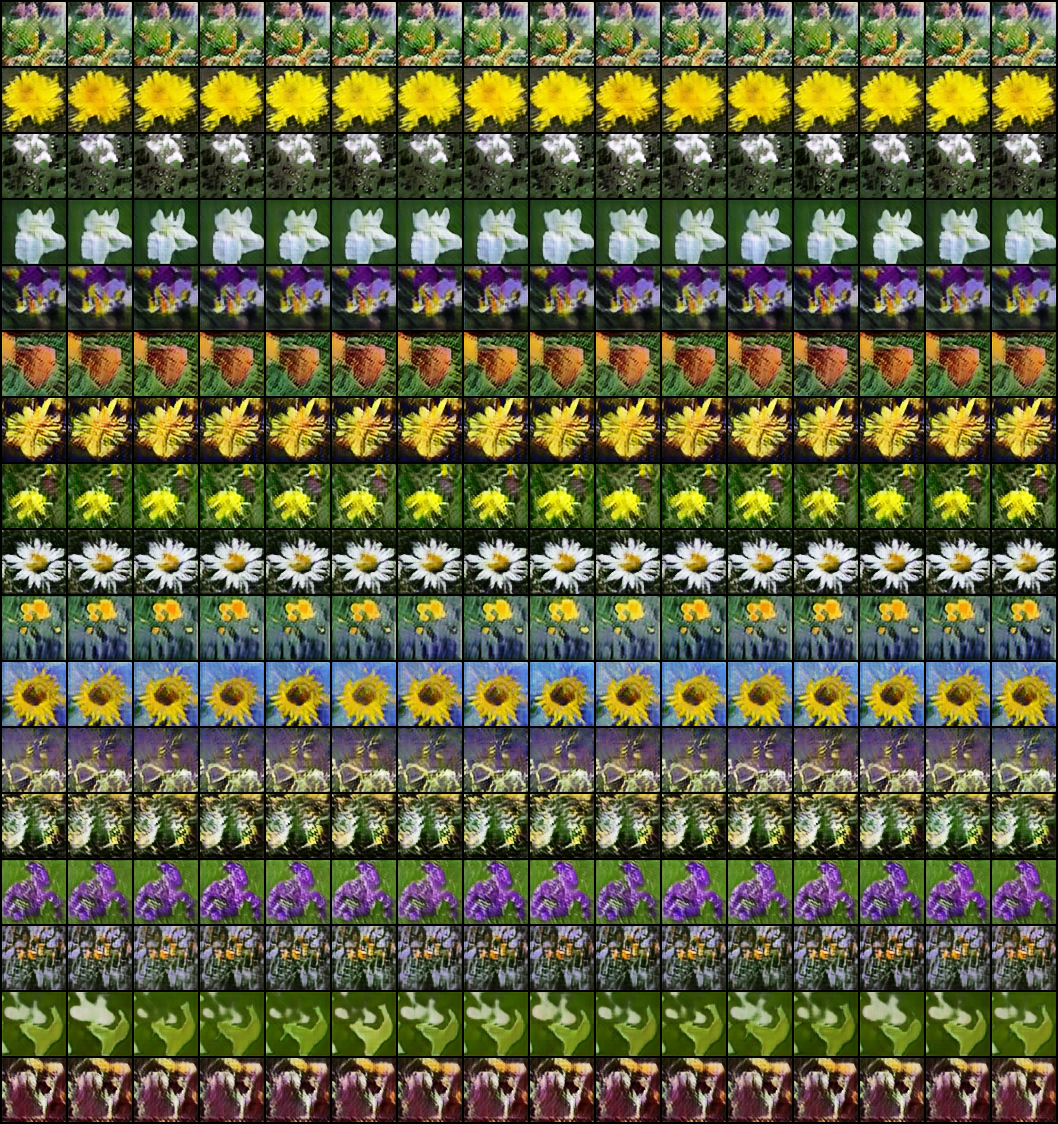

In [14]:
model = GAN(
    loss_type='hinge',
    class_conditional=True,
    truncation_trick=True, 
    data_path='datasets/flowers-17')
load_checkpoint(model, 'hinge_class-cond')

fid, inception_score = calc_eval_metrics(model.eval().cuda(), 'cuda' if use_gpu else 'cpu')

print(f'FID: {fid:.2f}, IS: {inception_score:.2f}')

visualize_image_grid(model)

## Part 3. Report

In this part, you will need to analyze and compare the quality and performance of the trained models. Like semantic segmentation homework.

### Task 1.

Compare the performance of two evaluated GAN losses both qualitatively (comparing generated images side-by-side) and quantitatively (via metrics). What objective leads to the best results?

Hinge             |  Non-saturating
:-------------------------:|:-------------------------:
![](pics/hinge.png)  |  ![](pics/non-saturating.png)
**FID: 131.05, IS: 2.91** | **FID: 132.35, IS: 2.79**

#### Difference is miserable, in terms of loss and score Hinge model performs better

### Task 2.
Compare (qualitatively and quantitatively) class conditional and non-class conditional models. Which one has better quality and metrics? Reflect and propose an explanation, why is that so?

Hinge             |  Conditional Hinge
:-------------------------:|:-------------------------:
![](pics/hinge.png)  |  ![](pics/hinge_cond_no_trick.png)
**FID: 131.05, IS: 2.91** | **FID: 107.92, IS: 3.92**

#### Here the difference is more obvious, small details, shades, etc. way too better for conditional approach

### Task 3.
Do the same comparison with and without truncation trick. Explain, what changes when this trick is applied, how it affects the results and their quality? Try to explain, why exactly truncation trick works this way?

Conditional Hinge             |  Conditional Hinge with trick
:-------------------------:|:-------------------------:
![](pics/hinge_cond_no_trick.png)  |  ![](pics/hinge_cond.png)
**FID: 131.05, IS: 2.91** | **FID: 110.66, IS: 3.86**

#### Finally, the difference is miserable, in terms of loss and score "tricky" model performs better. By the authors' statement it helps to remove some noise